# Population Receptive Field modelling
*Modeling the voxel-recorded receptive fields based on neuronal populations.*

In [256]:
import numpy as np
import scipy as sp
import scipy.signal as signal
import pandas as pd

import matplotlib

import matplotlib.pyplot as pl
%matplotlib inline 

import seaborn as sn
sn.set(style="ticks")

### Model

The measured pRF is the weighted sum of all the neurons' receptive fields, and cognitive factors


$$g_{pRF} = \sum_{p} (w(p) \cdot g_{nRF}(p))*g_{population} \cdot g_{cognition} + k $$

### Some functions and parameters

In [257]:
voxel_size = 1.0

In [258]:
def gauss_rf(x, m, s):
    return np.exp(-((x-m)**2)/s)

In [292]:
def create_neurons(nr_neuronal_rfs=1e3, 
                   neuron_ecc_size_int=0.25, 
                   neuron_ecc_size_slope=0.25,
                   neuron_max_ecc=10, 
                   neuron_max_mm_from_fovea=25,
                   neuron_ecc_sd=0.125,
                   neuron_size_sd=0.125,
                   neuron_mm_from_fovea_sd=0.125):
    
    neuron_mm_from_fovea = np.linspace(-neuron_max_mm_from_fovea, neuron_max_mm_from_fovea, nr_neuronal_rfs) + \
                                np.random.randn(int(nr_neuronal_rfs))*neuron_mm_from_fovea_sd
    neuron_eccentricities = np.r_[-(np.logspace(0,np.log10(neuron_max_ecc+1),nr_neuronal_rfs/2)-1)[::-1],
                                  np.logspace(0,np.log10(neuron_max_ecc+1),nr_neuronal_rfs/2)-1] + \
                                np.random.randn(int(nr_neuronal_rfs))*neuron_ecc_sd
    neuron_sizes = np.abs(neuron_ecc_size_int + np.abs(neuron_eccentricities * neuron_ecc_size_slope) + \
                                np.random.randn(int(nr_neuronal_rfs))*neuron_size_sd)

    # here's how to create a dataframe of neurons
    neurons = pd.DataFrame(np.array([neuron_mm_from_fovea, neuron_eccentricities, neuron_sizes]).T,
                columns = ['mm_from_fovea', 'ecc', 'size'])

    return neurons

In [272]:
def neurons_to_voxels(neurons, voxel_size, binning_column='mm_from_fovea'):
    """neurons_to_bold takes neurons and a voxel size 
    and returns the neurons' parameters in a per-voxel manner
    """
    bin_edges = np.linspace(-neuron_max_ecc,neuron_max_ecc,neuron_max_ecc/voxel_size)
    bin_indices = np.digitize(neurons[binning_column], bin_edges)
        
    mean_df = pd.DataFrame([
        neurons[bin_indices == bi].mean()
                                for bi in np.unique(bin_indices)])

    return mean_df 


In [ ]:
def combine_rfs(neurons, weight_column=None):
    """combine_rfs treats rfs as gaussian distributions, 
    and assumes that rfs are uncorrelated for now. Then,
    the mean and standard deviation of these distributions are defined as above."""

    if weight_column == None:
        weights = np.ones(len(neurons))
    else:
        weights = neurons[weight_column]

    ecc = np.sum(weights * neurons['ecc']) / len(neurons)
    size_var = np.sqrt(np.sum(weights**2 * neurons['size']**2))
    size_m = np.sum(weights * neurons['size']) / len(neurons)

    return ecc, size

### case for two gaussian rfs 
if $Z = aX_a + bX_b$, 

$$\mu_Z = a \cdot \mu_X + b \cdot \mu_Y$$, whereas 

$$\sigma_{Z}^{2} = a^2 \cdot \sigma_{X_a}^{2} + b^2 \cdot \sigma_{X_b}^{2}$$, or

$$\sigma_{Z} = \sqrt{a^2 \cdot \sigma_{X_A}^{2} + b^2 \cdot \sigma_{X_b}^{2}}$$


### case for n gaussian rfs 

$$\mu_Z = \sum_{n=0}^{N} a_{n} \cdot \mu_{X_n}$$

$$\sigma_{Z} = \sqrt{ \sum_{n=0}^{N} a_{n}^2 \cdot \sigma_{X_n}^{2}}$$





In [261]:
def gauss_AF_neurons(neurons, ecc_AF=0.0, size_AF=1.0):
    """model gaussian multiplication inside the voxel, at the neuronal level"""
    
    neurons['ecc_AF'] = (neurons['ecc'] * size_AF**2 + ecc_AF * neurons['size']**2) \
                        / (neurons['size']**2 + size_AF**2)
    neurons['size_AF'] = np.sqrt((neurons['size']**2 * size_AF**2) \
                        / (neurons['size']**2 + size_AF**2)) 

### Changing the neuronal response properties: effects on voxel-based measurements

#### First, we change the eccentricity-size relationships, by varying its offset and slope 

/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


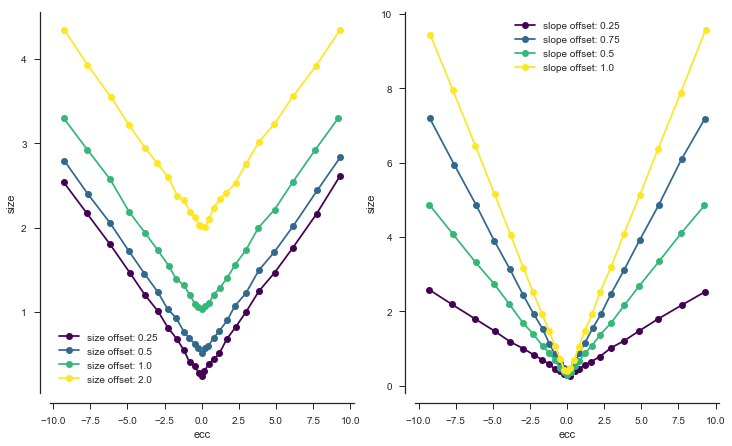

In [293]:
size_offsets = [0.25,0.5,1.0,2.0] 
col = pl.cm.viridis(np.linspace(0,1,len(size_offsets)))

f = pl.figure(figsize=(12,7))
s = f.add_subplot(121)
s.set_ylabel('size')
s.set_xlabel('ecc')
for i, s in enumerate(size_offsets):
    mean_df = neurons_to_voxels(create_neurons(neuron_ecc_size_int=s), 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'size offset: ' + str(s))
pl.legend()
sn.despine(offset=10)

slope_offsets = [0.25,0.75,0.5,1.0] 

# f = pl.figure(figsize=(9,9))
s = f.add_subplot(122)
s.set_ylabel('size')
s.set_xlabel('ecc')
for i, s in enumerate(slope_offsets):
    mean_df = neurons_to_voxels(create_neurons(neuron_ecc_size_slope=s), 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'slope offset: ' + str(s))
pl.legend()
sn.despine(offset=10)

#### We can also add noise, to the locations and sizes and both, through the sampling on the surface.

/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


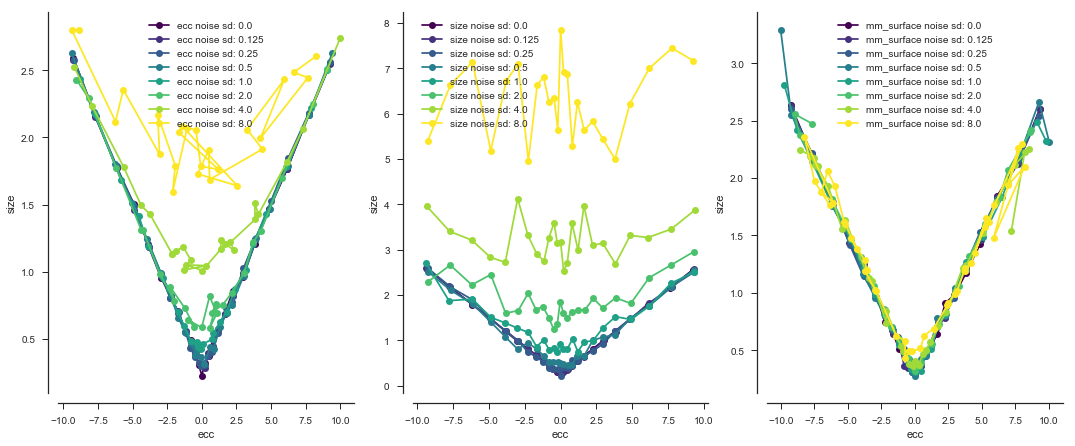

In [294]:
ecc_sds = [0.0, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0] 
col = pl.cm.viridis(np.linspace(0,1,len(ecc_sds)))

f = pl.figure(figsize=(18,7))
s = f.add_subplot(131)
s.set_ylabel('size')
s.set_xlabel('ecc')
for i, s in enumerate(ecc_sds):
    mean_df = neurons_to_voxels(create_neurons(neuron_ecc_sd=s), 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'ecc noise sd: ' + str(s))
pl.legend()
sn.despine(offset=10)

size_sds = [0.0, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0] 

# f = pl.figure(figsize=(9,9))
s = f.add_subplot(132)
s.set_ylabel('size')
s.set_xlabel('ecc')
for i, s in enumerate(size_sds):
    mean_df = neurons_to_voxels(create_neurons(neuron_size_sd=s), 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'size noise sd: ' + str(s))
pl.legend()
sn.despine(offset=10)

mm_sds = [0.0, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0] 

# f = pl.figure(figsize=(9,9))
s = f.add_subplot(133)
s.set_ylabel('size')
s.set_xlabel('ecc')
for i, s in enumerate(mm_sds):
    mean_df = neurons_to_voxels(create_neurons(neuron_size_sd=0.25, neuron_mm_from_fovea_sd=s), 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'mm_surface noise sd: ' + str(s))
pl.legend()
sn.despine(offset=10)

#### Then, we can simulate a stimulus that progressively activates specific visual pathways that are both represented in a given voxel, for example parvocellular vs. magnocellular.

/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


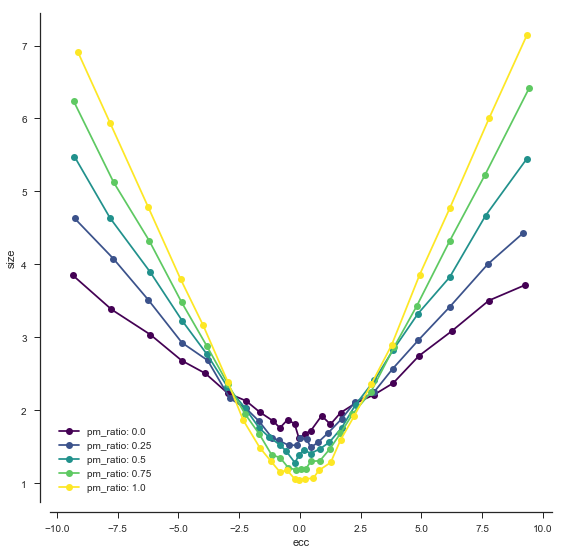

In [295]:
pm_ratios = [0.0, 0.25, 0.5, 0.75, 1.0] 
col = pl.cm.viridis(np.linspace(0,1,len(pm_ratios)))
nr_neurons = 1e4
p_slope, m_slope = 0.75, 0.25
p_int, m_int = 0.125, 1.5

f = pl.figure(figsize=(9,9))
s = f.add_subplot(111)
s.set_ylabel('size')
s.set_xlabel('ecc')
for i, pmr in enumerate(pm_ratios):
    
    p_neurons = create_neurons(nr_neuronal_rfs=nr_neurons*pmr, 
                                neuron_ecc_size_int=p_int,
                                neuron_ecc_size_slope=p_slope,
                                neuron_ecc_sd=1.0,
                                neuron_size_sd=1.0)
    m_neurons = create_neurons(nr_neuronal_rfs=nr_neurons*(1-pmr), 
                                neuron_ecc_size_int=m_int,
                                neuron_ecc_size_slope=m_slope,
                                neuron_ecc_sd=1.0,
                                neuron_size_sd=1.0)   
    
    neurons = pd.concat([p_neurons, m_neurons])
    
    mean_df = neurons_to_voxels(neurons, 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    pl.plot(mean_df['ecc'], mean_df['size'], c = col[i], marker = 'o', label = 'pm_ratio: ' + str(pmr))
pl.legend()
sn.despine(offset=10)

#### First forays into attention field interactions, i.e. $g_{cognition}$

/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/knapen/miniconda3/envs/i3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


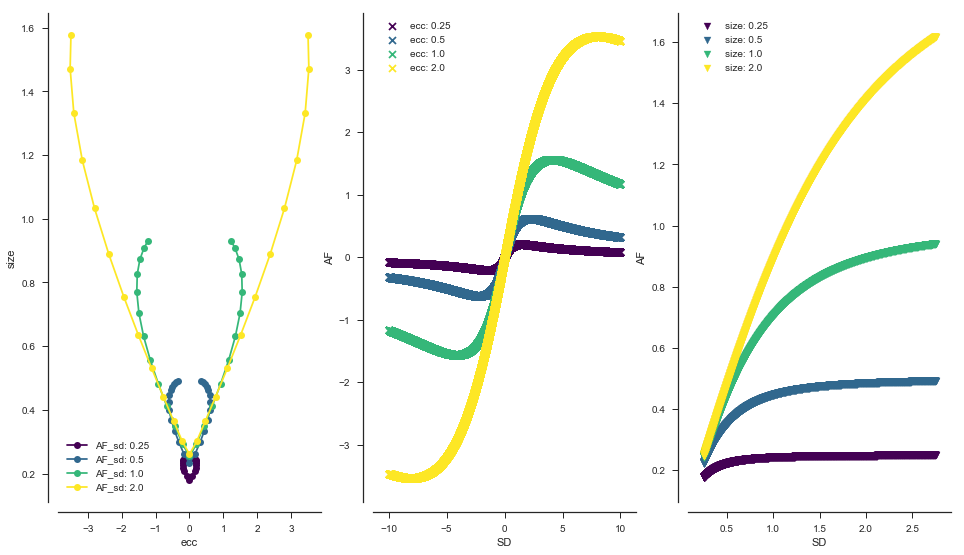

In [300]:
AF_sds = [0.25, 0.5, 1.0, 2.0] 
col = pl.cm.viridis(np.linspace(0,1,len(AF_sds)))
nr_neurons = 1e4

f = pl.figure(figsize=(16,9))
s = f.add_subplot(131)
s.set_ylabel('size')
s.set_xlabel('ecc')
s2 = f.add_subplot(132)
s2.set_xlabel('SD')
s2.set_ylabel('AF')
s3 = f.add_subplot(133)
s3.set_xlabel('SD')
s3.set_ylabel('AF')
for i, afs in enumerate(AF_sds):
    
    neurons = create_neurons(nr_neuronal_rfs=nr_neurons*pmr, 
                                neuron_ecc_size_int=0.25,
                                neuron_ecc_size_slope=0.25,
                                neuron_ecc_sd=0.0,
                                neuron_size_sd=0.0,
                                neuron_mm_from_fovea_sd=0.0)

    gauss_AF_neurons(neurons, ecc_AF=0.0, size_AF=afs)
    
    mean_df = neurons_to_voxels(neurons, 
                                voxel_size=voxel_size, binning_column='mm_from_fovea')
    s.plot(mean_df['ecc_AF'], mean_df['size_AF'], c = col[i], marker = 'o', label = 'AF_sd: ' + str(afs))
    
    s2.scatter(neurons['ecc'], neurons['ecc_AF'], color=col[i], marker='x', label = 'ecc: ' + str(afs) )
    s3.scatter(neurons['size'], neurons['size_AF'], color=col[i], marker='v', label = 'size: ' + str(afs) )

s.legend()
s2.legend()
s3.legend()

sn.despine(offset=10)


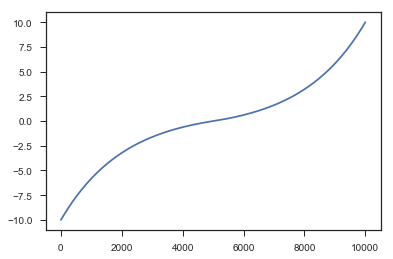

In [297]:
pl.plot(neurons.ecc)

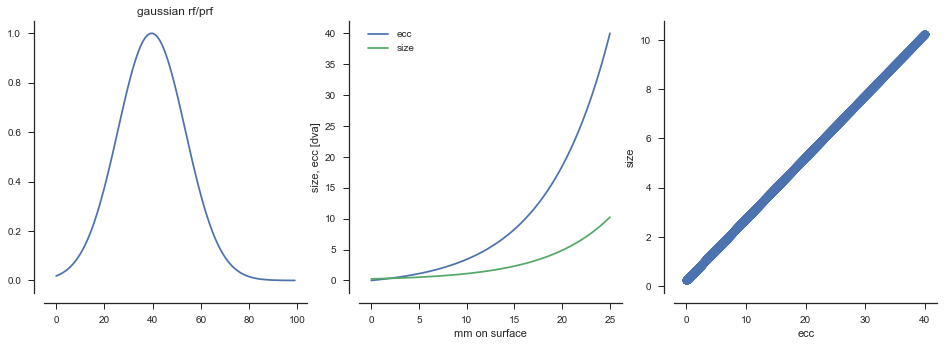

In [298]:
f = pl.figure(figsize=(16,5))
s = f.add_subplot(131)
pl.plot(gauss_rf(np.linspace(0,5,100), 2, 1))
s.set_title('gaussian rf/prf')
sn.despine(offset=10)
s = f.add_subplot(132)
pl.plot(neuron_mm_from_fovea, neuron_eccentricities)
pl.plot(neuron_mm_from_fovea, neuron_sizes)
pl.legend(['ecc','size'])
s.set_xlabel('mm on surface');
s.set_ylabel('size, ecc [dva]');
sn.despine(offset=10)
s = f.add_subplot(133)
pl.scatter(neuron_eccentricities, neuron_sizes)
s.set_xlabel('ecc')
sn.despine(offset=10)
s.set_ylabel('size');